<a href="https://colab.research.google.com/github/AyushiNM/ASL-Recognization/blob/main/Sign_Language_Alphabet_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget https://github.com/loicmarie/sign-language-alphabet-recognizer/archive/refs/heads/master.zip

In [ ]:
! unzip master.zip

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, Subset
import matplotlib.pyplot as plt
import time
import os
import copy

: 

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_transforms = transforms.Compose([transforms.ColorJitter(brightness=.5),
                              transforms.RandomRotation(degrees=(0, 180)),
                              transforms.Resize(355), 
                              transforms.CenterCrop(299),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(355), 
                                  transforms.CenterCrop(299),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
dataset = datasets.ImageFolder('/content/sign-language-alphabet-recognizer-master/dataset')

In [ ]:
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

In [ ]:
train_dataset = MyLazyDataset(dataset, train_transforms)
val_dataset = MyLazyDataset(dataset, test_transforms)
test_dataset = MyLazyDataset(dataset, test_transforms)

In [ ]:
# Create the index splits for training, validation and test

train_size = 0.8
num_images = len(dataset)
indices = list(range(num_images))
train_split = int(np.floor(train_size * num_images))
test_split = int(np.floor((train_size + (1 - train_size) / 2) * num_images))

np.random.shuffle(indices)

train_indices, valid_indices, test_indices = indices[:train_split], indices[train_split:test_split], indices[test_split:]

train_data = Subset(train_dataset, indices = train_indices)
val_data = Subset(val_dataset, indices = valid_indices)
test_data = Subset(test_dataset, indices = test_indices)

In [ ]:
num_workers = 2
batch_size = 64

if __name__ == '__main__':
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                              num_workers=num_workers, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                            num_workers=num_workers, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                             num_workers=num_workers, drop_last=True)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


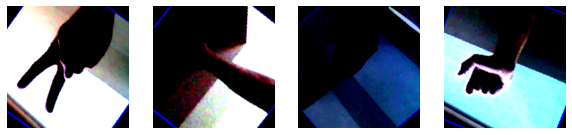

In [ ]:
data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

# Test Data Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4)
tensor(24)
tensor(1)
tensor(27)


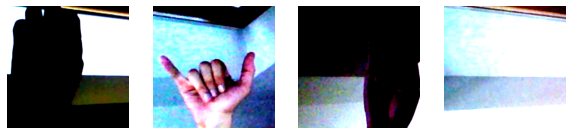

In [ ]:
data_iter = iter(test_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)
    print(labels[ii])

In [ ]:
class_names = dataset.classes

In [ ]:
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                dataset_size = len(train_data)
                model.train()  # Set model to training mode
            else:
                dataset_size = len(val_data)
                dataloader = val_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.inception_v3(pretrained=True)
model_ft.aux_logits=False
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

In [ ]:
def evaluate_model(model):

    running_loss = 0.0
    running_corrects = 0

    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_data)
        epoch_acc = running_corrects.double() / len(test_data)

        phase = "Test"

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [ ]:
evaluate_model(model_ft)

Test Loss: 0.0146 Acc: 0.9899


In [ ]:
torch.save(model_ft.state_dict(), f'/content/drive/My Drive/Colab Notebooks/Inception_v3.model')

References -
1. https://discuss.pytorch.org/t/using-imagefolder-random-split-with-multiple-transforms/79899/4
2. https://www.kaggle.com/leifuer/intro-to-pytorch-loading-image-data
